In [ ]:
#Libraries
import pandas as pd
import numpy as np
import torch
import os
from datasets import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
from googletrans import Translator
import random, time
import sentencepiece
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5Tokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, AutoModelForSequenceClassification
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


import warnings
warnings.filterwarnings('ignore')


# Google Colab or not
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data from Google Drive: {path}")
else:
    path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data locally from: {path}")


# GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU ready:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU detecting, using CPU.")

c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data locally from: C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining
No GPU detecting, using CPU.


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
MODEL_NAME = "roberta-base"  # wE CAn change this to any model you want to use

In [ ]:
#Load Dataset
train_path = f"{path}/data/train.csv"
dev_path   = f"{path}/data/dev.csv"
test_path  = f"{path}/data/test.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)


# Map labels to ints
label2id = {"oppose": 0, "support": 1}
for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(label2id)

df_train.head()


dataset_train = Dataset.from_pandas(df_train[["tweet_text", "label"]])
dataset_dev   = Dataset.from_pandas(df_dev[["tweet_text", "label"]])
dataset_test  = Dataset.from_pandas(df_test[["tweet_text", "label"]])


Train class distribution:
Stance value counts:
 stance
oppose     1095
support     719
Name: count, dtype: int64


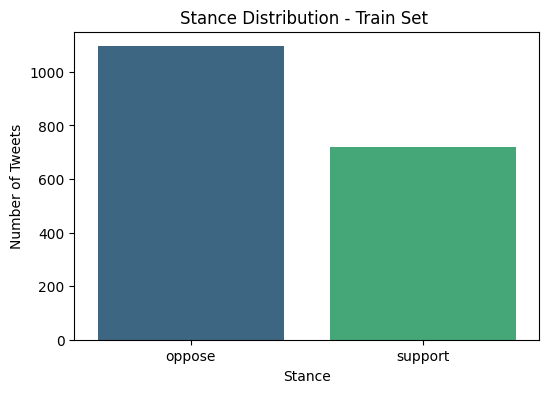

In [ ]:
print("Train class distribution:")
stance_counts = df_train['stance'].value_counts()
print("Stance value counts:\n", stance_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=stance_counts.index, y=stance_counts.values, palette="viridis")
plt.title("Stance Distribution - Train Set ")
plt.ylabel("Number of Tweets")
plt.xlabel("Stance")
plt.show()

## Data Augmentation Techniques 

### Synonym Replacement (WordNet)

This technique randomly selects words in a sentence (excluding stop words) and replaces them with synonyms obtained from a lexical database like WordNet. The goal is to create semantically similar sentences without changing the meaning.  

**Example:**  
Original: "Gun control laws should be stricter to reduce crime."  
Augmented: "Firearm regulation rules should be tougher to reduce crime."


In [ ]:
def augment_synonym(texts, n=1):
    aug = naw.SynonymAug(aug_p=0.2) #aug_p = probability of words to be augmented.
    augmented = [aug.augment(t) for t in texts for _ in range(n)]
    return augmented

### Back Translation

Back translation involves translating a sentence to another language and then translating it back to the original language. This introduces natural paraphrases and linguistic variations.  

**Example:**  
Original: "We need stronger gun regulations."  
Augmented: "It is necessary to have stricter firearm laws."


In [ ]:
def back_translate(texts, n=1, sleep_time=0.3):
    translator = Translator()
    augmented = []
    for t in texts:
        try:
            fr = translator.translate(t, src="en", dest="fr").text
            back = translator.translate(fr, src="fr", dest="en").text
            augmented.append(back)
            time.sleep(sleep_time)
        except:
            continue
    return augmented


### Paraphrasing with T5 / Pegasus

Paraphrasing models (like T5 or Pegasus) generate alternative ways of writing a sentence while preserving its meaning. These models are trained on large datasets of paraphrase pairs.  

**Example:**  
Original: "The Second Amendment should be reconsidered."  
Augmented: "We should rethink the Second Amendment."


In [ ]:

tokenizer = T5Tokenizer.from_pretrained("t5-base", use_fast=False)
para_tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")
para_model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")

def augment_paraphrase(texts, n=1):
    augmented = []
    for t in texts:
        input_text = f"paraphrase: {t} </s>"
        encoding = para_tokenizer.encode_plus(input_text, return_tensors="pt", truncation=True)
        outputs = para_model.generate(
            **encoding, max_length=128, num_beams=5, num_return_sequences=n
        )
        for output in outputs:
            augmented.append(para_tokenizer.decode(output, skip_special_tokens=True))
    return augmented

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### Noise Injection

Randomly removes or inserts words in a sentence, introducing small perturbations. This simulates noisy text, such as typos or incomplete sentences.  

**Example:**  
Original: "Gun control laws need to be enforced strictly."  
Augmented: "Gun laws need enforced strictly."


In [ ]:
def augment_noise(texts, del_prob=0.1):
    augmented = []
    for t in texts:
        words = t.split()
        new_words = [w for w in words if random.random() > del_prob]
        augmented.append(" ".join(new_words))
    return augmented


## Generate our Augmented Datasets

In [ ]:
minority_df = df_train[df_train["label"] == 1]
n_samples = len(df_train[df_train["label"] == 0]) - len(minority_df)
texts_to_augment = minority_df["tweet_text"].tolist()

augmentations = {
    "synonym": augment_synonym,
    "back_translation": back_translate,
    "paraphrase": augment_paraphrase,
    "noise": augment_noise
}

# Generate our augmented datasets
augmented_datasets = {}

for name, func in augmentations.items():
    print(f"Generating dataset with technique: {name}...")

    augmented_texts = func(texts_to_augment[:n_samples])
    #augmented_texts = augmented_texts[:n_samples]
    
    new_df = pd.concat([
        df_train,
        pd.DataFrame({
            "tweet_text": augmented_texts,
            "stance": "support",
            "label": 1
        })
    ], ignore_index=True)
    
    augmented_datasets[name] = new_df

KeyboardInterrupt: 

In [ ]:
# Visualize augmented datasets distribution
for name, df_aug in augmented_datasets.items():
    stance_counts = df_aug['stance'].value_counts()
    
    plt.figure(figsize=(6,4))
    sns.barplot(x=stance_counts.index, y=stance_counts.values, palette="viridis")
    plt.title(f"Stance Distribution - {name.capitalize()} Augmentation")
    plt.ylabel("Number of Tweets")
    plt.xlabel("Stance")
    plt.show()

In [ ]:
#Metrics we are going to evaluate
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro")
    }


In [ ]:

# Tokenization Function for each model
def tokenize_dataset(dataset, tokenizer, max_length=105):

    def tokenize_batch(batch):
        return tokenizer(batch["tweet_text"],padding="max_length",truncation=True,max_length=max_length)

    tokenized = dataset.map(tokenize_batch, batched=True)

    tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    return tokenized

In [ ]:
# Train and evaluate function
def train_and_evaluate(model_name, train_dataset, dev_dataset, test_dataset, seed=42, max_len=105):
    
    #Set Seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)


    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print(f"Tokenizer loaded for {model_name}...")

    # Tokenize datasets with model tokenizer
    train_dataset_tok = tokenize_dataset(train_dataset, tokenizer, 105)
    dev_dataset_tok = tokenize_dataset(dev_dataset, tokenizer, 105)
    test_dataset_tok = tokenize_dataset(test_dataset, tokenizer, 105)
    print(f"Tokenization complete")    

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    print(f"Model Loaded: {model_name}.")


    # TrainingArguments
    training_args = TrainingArguments(
        output_dir=f"./temp_models/{model_name.replace('/', '_')}_seed{seed}",
        eval_strategy="epoch",
        save_strategy="no", 
        logging_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
        logging_steps=10
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_tok,
        eval_dataset=dev_dataset_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train
    print(f"\n Starting training...")
    trainer.train()

    # Predictions on TEST set
    print(f"\n Getting predictions on TEST set...")
    predictions_output = trainer.predict(test_dataset_tok)
    y_pred = np.argmax(predictions_output.predictions, axis=1)
    y_true = predictions_output.label_ids


    # Metrics
    metrics = compute_metrics(predictions_output)
    metrics["y_true"] = y_true
    metrics["y_pred"] = y_pred

    print(f"\n Results for {model_name}:")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1-Score:  {metrics['f1']:.4f}")

    # Cleanup
    del model, trainer, train_dataset_tok, dev_dataset_tok, test_dataset_tok
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return metrics


In [ ]:
results_all = []

for technique_name, df_aug in augmented_datasets.items():
    print(f"\nTraining with augmentation: {technique_name}")
    dataset_aug = Dataset.from_pandas(df_aug[["tweet_text","label"]])

    metrics = train_and_evaluate(
        model_name=MODEL_NAME,
        train_dataset=dataset_aug,
        dev_dataset=dataset_dev,
        test_dataset=dataset_test,
        seed=42
    )

    metrics["technique"] = technique_name
    results_all.append(metrics)


In [ ]:
results_df = pd.DataFrame(results_all)
results_df = results_df.sort_values("f1", ascending=False)

# Print
print(results_df[["technique","accuracy","precision","recall","f1"]])

# Confusion matrices
for idx, row in results_df.iterrows():
    cm = confusion_matrix(row["y_true"], row["y_pred"], labels=[0,1])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["oppose","support"], yticklabels=["oppose","support"])
    plt.title(f"Confusion Matrix - {row['technique']}\nF1: {row['f1']:.4f}")
    plt.show()
